In [2]:
# instance normalization을 편하게 사용하기 위한 라이브러리 설치
# !pip install tensorflow-addons

In [1]:
# 필요한 라이브러리들 import
import os
import glob
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # 우리는 0 또는 1

2023-09-27 04:35:08.752930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/j-j9a306/.local/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [10]:
target_name = "space"
base_path = "./"

In [11]:
# from google.colab import drive
# drive.mount('/tmp/drive')

### 모델 로드

In [12]:
class Residual_Block(tf.keras.Model):
    '''
    Residual Block 클래스:
        Conv2d - InstanceNorm - Relu - Conv2d - InstanceNorm - Add(Residual Connection) 으로 구성
        artifact를 줄이기 위해 reflection padding 채택
    '''

    def __init__(self, input_channels):
        super(Residual_Block, self).__init__()

        self.conv_1 = tf.keras.layers.Conv2D(filters=input_channels, kernel_size=3, padding='valid', use_bias=False,
                                             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.instance_norm_1 = tfa.layers.InstanceNormalization()

        self.conv_2 = tf.keras.layers.Conv2D(filters=input_channels, kernel_size=3, padding='valid', use_bias=False,
                                             kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.instance_norm_2 = tfa.layers.InstanceNormalization()

        self.activation = tf.keras.layers.ReLU()

    def reflection_pad(self, input, pad_size):
        return tf.pad(input, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')

    def call(self, inputs):
        x = self.reflection_pad(inputs, 1)
        x = self.conv_1(x)
        x = self.instance_norm_1(x)
        x = self.activation(x)

        x = self.reflection_pad(x, 1)
        x = self.conv_2(x)
        x = self.instance_norm_2(x)

        return x + inputs

In [13]:
class Pix2Pix_Generator(tf.keras.Model):
    '''
    Pix2Pix Generator 클래스:
        contracting block + 9 residual blocks + expanding block 으로 구성 => CycleGAN에서의 generator
        (기존 U-net 기반 방식 대신 resnet 기반 방식을 채택)
    '''

    def __init__(self, input_channels, output_channels, hidden_channels=64, name=""):
        super(Pix2Pix_Generator, self).__init__()

        if name:
            self._name = name

        # CycleGAN 저자들의 notation 참고
        # for c7s1-64
        self.c7s1_64_conv = tf.keras.layers.Conv2D(filters=hidden_channels, kernel_size=7, padding='valid', use_bias=False,
                                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.c7s1_64_instance_norm = tfa.layers.InstanceNormalization()

        # for d128
        self.d128_conv = tf.keras.layers.Conv2D(filters=2*hidden_channels, kernel_size=3, strides=2, padding='valid', use_bias=False,
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.d128_instance_norm = tfa.layers.InstanceNormalization()

        # for d256
        self.d256_conv = tf.keras.layers.Conv2D(filters=4*hidden_channels, kernel_size=3, strides=2, padding='valid', use_bias=False,
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.d256_instance_norm = tfa.layers.InstanceNormalization()

        # for residual blocks
        R_channels = 4*hidden_channels
        self.R256_1 = Residual_Block(R_channels)
        self.R256_2 = Residual_Block(R_channels)
        self.R256_3 = Residual_Block(R_channels)
        self.R256_4 = Residual_Block(R_channels)
        self.R256_5 = Residual_Block(R_channels)
        self.R256_6 = Residual_Block(R_channels)
        self.R256_7 = Residual_Block(R_channels)
        self.R256_8 = Residual_Block(R_channels)
        self.R256_9 = Residual_Block(R_channels)

        # for u128
        self.u128_conv_transpose = tf.keras.layers.Conv2DTranspose(filters=2*hidden_channels, kernel_size=3, strides=2, padding='same', use_bias=False,
                                                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.u128_instance_norm = tfa.layers.InstanceNormalization()

        # for u256
        self.u256_conv_transpose = tf.keras.layers.Conv2DTranspose(filters=hidden_channels, kernel_size=3, strides=2, padding='same', use_bias=False,
                                                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.u256_instance_norm = tfa.layers.InstanceNormalization()

        # for c7s1-3
        self.c7s1_3_conv = tf.keras.layers.Conv2D(filters=output_channels, kernel_size=7, padding='valid',
                                                  kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))

        # activation
        self.relu = tf.keras.layers.ReLU()


    def reflection_pad(self, input, pad_size):
        return tf.pad(input, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')


    def call(self, inputs):
        # c7s1-64
        x = self.reflection_pad(inputs, 3)
        x = self.c7s1_64_conv(x)
        x = self.c7s1_64_instance_norm(x)
        x = self.relu(x)

        # d128
        x = self.reflection_pad(x, 1)
        x = self.d128_conv(x)
        x = self.d128_instance_norm(x)
        x = self.relu(x)

        # d256
        x = self.reflection_pad(x, 1)
        x = self.d256_conv(x)
        x = self.d256_instance_norm(x)
        x = self.relu(x)

        # R256_1~9
        x = self.R256_1(x)
        x = self.R256_2(x)
        x = self.R256_3(x)
        x = self.R256_4(x)
        x = self.R256_5(x)
        x = self.R256_6(x)
        x = self.R256_7(x)
        x = self.R256_8(x)
        x = self.R256_9(x)

        # u128
        x = self.u128_conv_transpose(x)
        x = self.u128_instance_norm(x)
        x = self.relu(x)

        # u256
        x = self.u256_conv_transpose(x)
        x = self.u256_instance_norm(x)
        x = self.relu(x)

        # c7s1-3
        x = self.reflection_pad(x, 3)
        x = self.c7s1_3_conv(x)

        return tf.keras.activations.tanh(x)


In [14]:
class Pix2Pix_discriminator(tf.keras.Model):
    '''
    PatchGAN discriminator 클래스:
        receptive field size : 70
    '''

    def __init__(self, input_channels, hidden_channels=64, name=""):
        super(Pix2Pix_discriminator, self).__init__()

        if name:
            self._name = name

        # for C64
        self.C64_conv = tf.keras.layers.Conv2D(filters=hidden_channels, kernel_size=4, strides=2, padding='valid', use_bias=True,
                                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))

        # for C128
        self.C128_conv = tf.keras.layers.Conv2D(filters=2*hidden_channels, kernel_size=4, strides=2, padding='valid', use_bias=False,
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.C128_instance_norm = tfa.layers.InstanceNormalization()

        # for C256
        self.C256_conv = tf.keras.layers.Conv2D(filters=4*hidden_channels, kernel_size=4, strides=2, padding='valid', use_bias=False,
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.C256_instance_norm = tfa.layers.InstanceNormalization()

        # for C512
        self.C512_conv = tf.keras.layers.Conv2D(filters=8*hidden_channels, kernel_size=4, strides=1, padding='valid', use_bias=False,
                                                kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))
        self.C512_instance_norm = tfa.layers.InstanceNormalization()

        # for output
        self.output_conv = tf.keras.layers.Conv2D(filters=1, kernel_size=4, strides=1, padding='valid', use_bias=True,
                                                  kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.02))

        # activation
        self.LeakyReLU = tf.keras.layers.LeakyReLU(alpha=0.2)


    def reflection_pad(self, input, pad_size):
        return tf.pad(input, [[0, 0], [pad_size, pad_size], [pad_size, pad_size], [0, 0]], mode='REFLECT')


    def call(self, inputs):
        # C64
        x = self.reflection_pad(inputs, 1)
        x = self.C64_conv(x)
        # 저자들이 처음 discriminator block에는 instance norm을 적용하지 않은 것을 참고
        x = self.LeakyReLU(x)

        # C128
        x = self.reflection_pad(x, 1)
        x = self.C128_conv(x)
        x = self.C128_instance_norm(x)
        x = self.LeakyReLU(x)

        # C256
        x = self.reflection_pad(x, 1)
        x = self.C256_conv(x)
        x = self.C256_instance_norm(x)
        x = self.LeakyReLU(x)

        # C512
        x = self.reflection_pad(x, 1)
        x = self.C512_conv(x)
        x = self.C512_instance_norm(x)
        x = self.LeakyReLU(x)

        # output
        x = self.reflection_pad(x, 1)
        x = self.output_conv(x)
        return x


In [15]:
generator = Pix2Pix_Generator(input_channels=1, output_channels=3, name=f"{target_name}_generator")
discriminator = Pix2Pix_discriminator(input_channels=4, name=f"{target_name}_discriminator")

if target_name == "cartoon_set":
    generator = Pix2Pix_Generator(input_channels=34, output_channels=3, name=f"{target_name}_generator")
    discriminator = Pix2Pix_discriminator(input_channels=37, name=f"{target_name}_discriminator")
    

# optimizer 초기화
learning_rate = 2e-4  # 0.0002

generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5, beta_2=0.999)

### Checkpoint 불러오기

In [16]:
# checkpoint_path
cur_model_checkpoint_directory = f"model_checkpoints/{target_name}/"
checkpoint_path = os.path.join(base_path, cur_model_checkpoint_directory)

# checkpoint
ckpt = tf.train.Checkpoint(generator=generator,
                           discriminator=discriminator,
                           generator_optimizer=generator_optimizer,
                           discriminator_optimizer=discriminator_optimizer)

# checkpoint manager
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

# if checkpoint exists, restore the latest checkpoint
# if ckpt_manager.latest_checkpoint:
    # ckpt.restore(ckpt_manager.latest_checkpoint)
# ckpt.restore('/tmp/drive/MyDrive/colab/checkpoints/cartoon_set/ckpt-28')
# ckpt.restore('/tmp/drive/MyDrive/colab/checkpoints/panda/ckpt-7')
# ckpt.restore('/tmp/drive/MyDrive/colab/checkpoints/bmw/ckpt-19')
# ckpt.restore('./model_checkpoints/cartoon_set/ckpt-2')
# ckpt.restore('./model_checkpoints/handbag/ckpt-5')
# ckpt.restore('./model_checkpoints/shark/ckpt-20')
# ckpt.restore('./model_checkpoints/shoe/ckpt-25')
# ckpt.restore('./model_checkpoints/maple_character/ckpt-14')
# ckpt.restore('./model_checkpoints/gemstone/ckpt-1')
ckpt.restore('./model_checkpoints/space/ckpt-1')
# print(ckpt_manager.checkpoints)
print('checkpoint restored!!')

checkpoint restored!!


### 그림 테스트

파일 업로드

2023-09-27 04:40:02.542339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]
2023-09-27 04:40:02.542575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8]
	 [[{{node Placeholder/_0}}]]


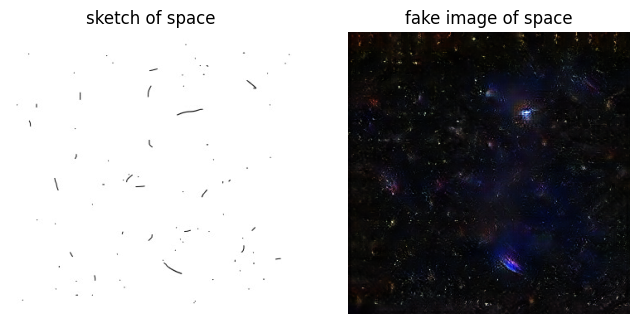

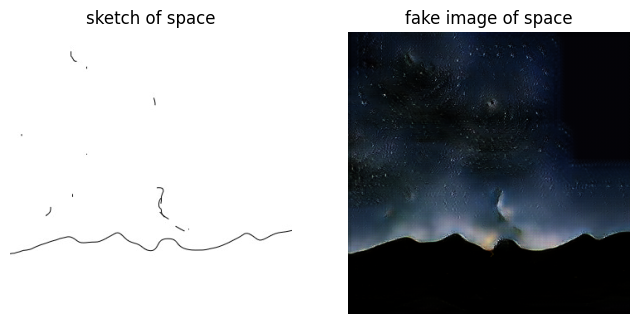

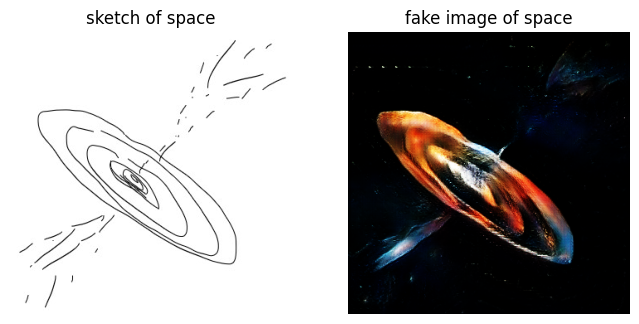

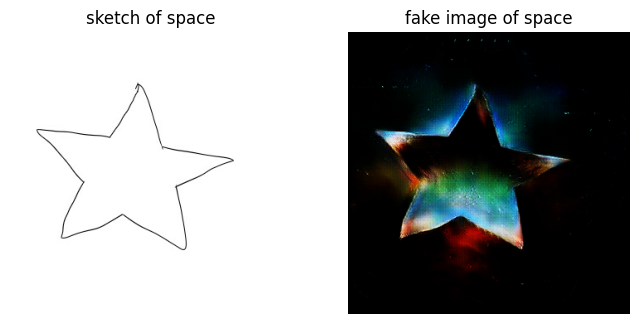

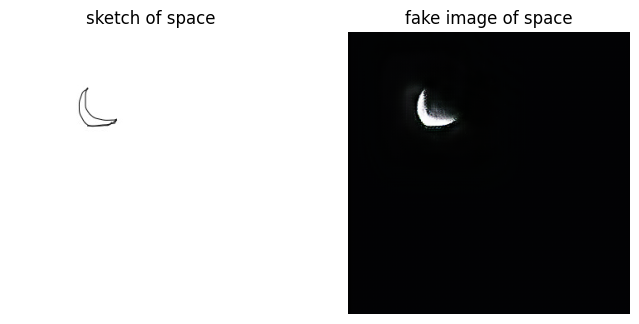

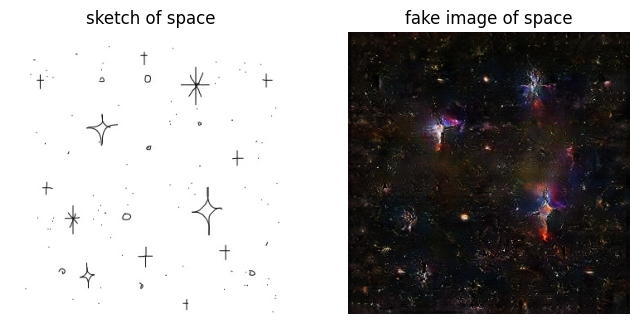

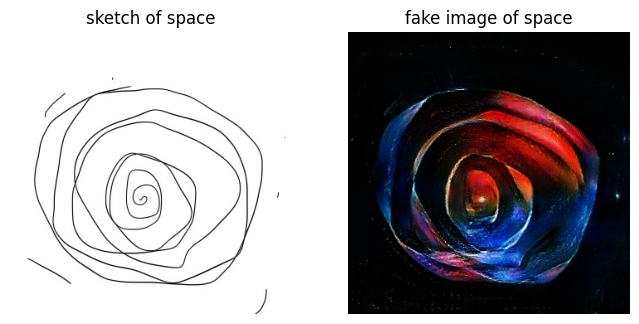

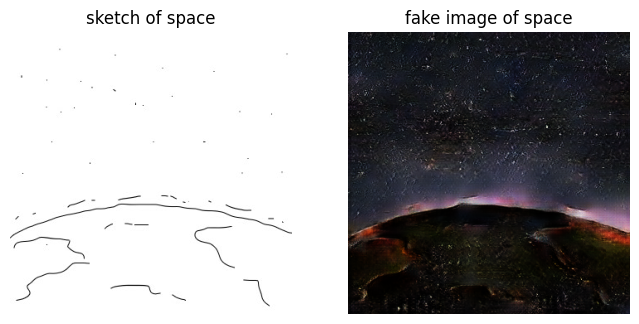

In [17]:
for file in tf.data.Dataset.list_files(os.path.join(base_path, f"test_edges/{target_name}/*.jpg")):
    edge_img = tf.io.decode_image(tf.io.read_file(file), channels=1, expand_animations = False)
    edge_img = tf.cast(edge_img, tf.float32)
    edge_img = edge_img / 255.0
    edge_img = tf.clip_by_value(edge_img, 0, 1)
    
    if target_name == "cartoon_set":
        RESIZE_SIZE = 256
        
        eye_color = tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32)                          # max = 4
        face_color = tf.random.uniform([], minval=0, maxval=10, dtype=tf.int32)                         # max = 10
        hair_color = tf.random.uniform([], minval=0, maxval=9, dtype=tf.int32)                         # max = 9
        glasses_color = tf.random.uniform([], minval=0, maxval=6, dtype=tf.int32)                      # max = 6
        
        eye_color_condition = tf.reshape(tf.one_hot(eye_color, 5, dtype=tf.float32), shape=(1, 1, 5))
        eye_color_condition = tf.broadcast_to(eye_color_condition, [RESIZE_SIZE, RESIZE_SIZE, 5])
        
        face_color_condition = tf.reshape(tf.one_hot(face_color, 11, dtype=tf.float32), shape=(1, 1, 11))
        face_color_condition = tf.broadcast_to(face_color_condition, [RESIZE_SIZE, RESIZE_SIZE, 11])
        
        hair_color_condition = tf.reshape(tf.one_hot(hair_color, 10, dtype=tf.float32), shape=(1, 1, 10))
        hair_color_condition = tf.broadcast_to(hair_color_condition, [RESIZE_SIZE, RESIZE_SIZE, 10])
        
        glasses_color_condition = tf.reshape(tf.one_hot(glasses_color, 7, dtype=tf.float32), shape=(1, 1, 7))
        glasses_color_condition = tf.broadcast_to(glasses_color_condition, [RESIZE_SIZE, RESIZE_SIZE, 7])
        
        edge_img = tf.concat([edge_img, eye_color_condition, face_color_condition, hair_color_condition, glasses_color_condition], axis=-1)
        edge_img = tf.clip_by_value(edge_img, 0, 1)
        
    edge_img = tf.expand_dims(edge_img, axis=0)

    result = generator(edge_img)
    result = (result + 1) / 2.0

    plt.figure(figsize=(8, 4))
    display_list = [edge_img[0, :, :, :1], result[0]]
    title = [f'sketch of {target_name}', f'fake image of {target_name}']
    # title = [f'sketch of car', f'fake image of car']
    color_map = ['gray', '']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        if color_map[i]:
            plt.imshow(display_list[i], color_map[i])
        else:
            plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

In [153]:
# release_model_checkpoint_directory = f"release/{target_name}/"
# release_checkpoint_path = os.path.join(base_path, release_model_checkpoint_directory)

# # release checkpoint
# release_ckpt = tf.train.Checkpoint(generator=generator)

# # release checkpoint manager
# release_ckpt_manager = tf.train.CheckpointManager(release_ckpt, release_checkpoint_path, max_to_keep=5)

# # release checkpoint 저장
# release_ckpt_save_path = release_ckpt_manager.save()